## IMDB movies analysis

The aim of this project was to analyse imdb movies dataset. During the project there were performed data cleaning and feature engineering. Some classification models also have been applied. There were also involved techniques to reduce number of dimensions and perform clustering.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import time

import mca
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score,learning_curve, train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

#### Data loading 

In [90]:
df=pd.read_csv('tmdb_5000_movies.csv')
#credits=pd.read_csv('tmdb_5000_credits.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [4]:
df.sample(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4011,2500000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,10676,"[{""id"": 1004, ""name"": ""commercial""}, {""id"": 13...",en,Halloween III: Season of the Witch,Dr. Daniel Challis and Ellie Grimbridge stumbl...,12.030456,"[{""name"": ""Universal Pictures"", ""id"": 33}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-10-22,14400000,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,...and now the earth will run with blood again!,Halloween III: Season of the Witch,5.0,229
1725,28000000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",http://www.warnerbros.com/blade-runner,78,"[{""id"": 310, ""name"": ""artificial intelligence""...",en,Blade Runner,In the smog-choked dystopian Los Angeles of 20...,94.056131,"[{""name"": ""Shaw Brothers"", ""id"": 5798}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-06-25,33139618,117.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Man has made his match... now it's his problem.,Blade Runner,7.9,3509
1366,35000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.devilwearspradamovie.com/,350,"[{""id"": 90, ""name"": ""paris""}, {""id"": 736, ""nam...",en,The Devil Wears Prada,The Devil Wears Prada is about a young journal...,83.893257,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-06-30,326551094,109.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Meet Andy Sachs. A million girls would kill to...,The Devil Wears Prada,7.0,3088


In [5]:
df.isnull().any()

budget                  False
genres                  False
homepage                 True
id                      False
keywords                False
original_language       False
original_title          False
overview                 True
popularity              False
production_companies    False
production_countries    False
release_date             True
revenue                 False
runtime                  True
spoken_languages        False
status                  False
tagline                  True
title                   False
vote_average            False
vote_count              False
dtype: bool

In [60]:
df['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

As we can see some columns contains data in json format. Moreover there are many values in these columns for one record, for example many categories of movies.

In [6]:
df['status'].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

Some columns like status has low diversity so they are rather not important.

On the histogram below we can see that votes are not equaly distributed. Votes below 4 and more thsn 8 are very rare. It is problem to predict such categories or perform properly clustering with such small amount of records.

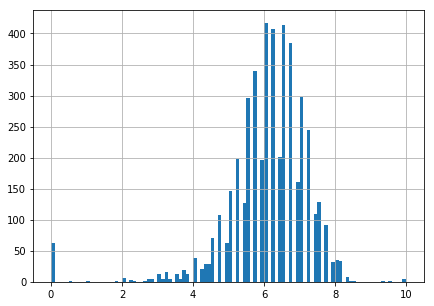

In [6]:
df['vote_average'].hist(bins=100,figsize=(7,5))

Distribution of vote counts, budget and revenue are highly skewed.

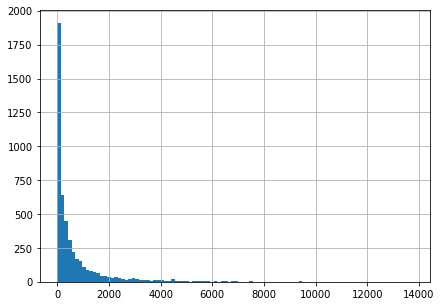

In [8]:
df['vote_count'].hist(bins=100,figsize=(7,5))

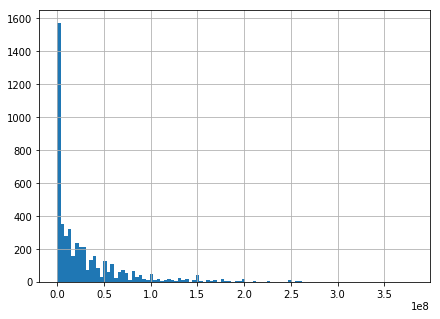

In [9]:
df['budget'].hist(bins=100,figsize=(7,5))

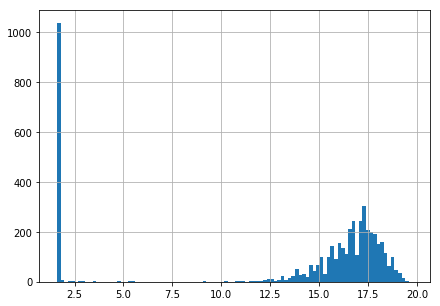

In [58]:
np.log(df['budget']+5).hist(bins=100,figsize=(7,5))

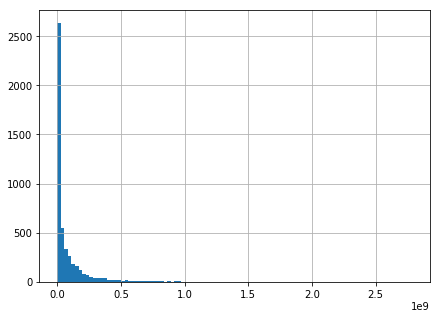

In [10]:
df['revenue'].hist(bins=100,figsize=(7,5))

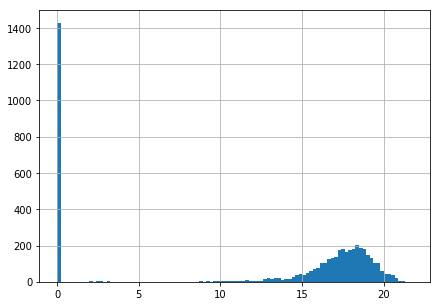

In [60]:
np.log(df['revenue']+1).hist(bins=100,figsize=(7,5))

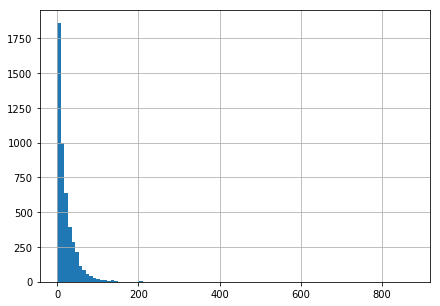

In [61]:
df['popularity'].hist(bins=100,figsize=(7,5))

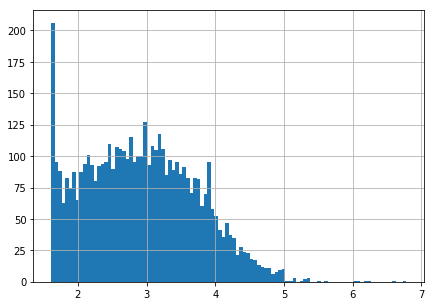

In [68]:
np.log(df['popularity']+5).hist(bins=100,figsize=(7,5))

Logarithmic transormation has been applied in the process of feature engineering.

In [11]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


I've added new feature contains year when movie was released. Furthermore class of vote has been round to perform classification.

In [91]:
df=df.fillna(-1)
df['release_date']=pd.to_datetime(df['release_date'])
df['release_year']=df['release_date'].dt.year
df['vote_class']=np.floor(df['vote_average']).astype(int)

As it has been mentioned before distribution of classes are not equal. There is also class 0 when movies have no votes. 

In [8]:
df['vote_class'].value_counts()

6     1984
5     1303
7      903
4      356
3       84
8       79
0       64
2       21
10       4
1        3
9        2
Name: vote_class, dtype: int64

In [9]:
df[df['vote_class']==0][['title','vote_count','vote_average']].sample(10)

,title,vote_count,vote_average
4708,Heroes of Dirt,0,0.0
4721,The Work and The Story,0,0.0
4444,Elza,0,0.0
4266,House at the End of the Drive,0,0.0
4309,The Blade of Don Juan,0,0.0
4692,Theresa Is a Mother,0,0.0
4068,Sharkskin,0,0.0
3855,Time to Choose,0,0.0
4626,Anderson's Cross,0,0.0
4186,A Beginner's Guide to Snuff,0,0.0


In [26]:
df[df['vote_class']==2][['title','vote_count','vote_average']].sample(10)

,title,vote_count,vote_average
4276,Def-Con 4,10,2.8
4566,Diamond Ruff,4,2.4
4621,Royal Kill,6,2.8
4562,The Little Ponderosa Zoo,1,2.0
3970,AWOL-72,10,2.8
2601,Barney's Great Adventure,8,2.9
3964,30 Nights of Paranormal Activity With the Devi...,28,2.9
1101,Foodfight!,28,2.3
4318,Bleeding Hearts,1,2.0
4278,Neal 'n' Nikki,4,2.3


In [45]:
df[(df['vote_class']==9) | (df['vote_class']==10)][['title','vote_count','vote_average']]

,title,vote_count,vote_average
2386,One Man's Hero,2,9.3
3519,Stiff Upper Lips,1,10.0
3992,Sardaarji,2,9.5
4045,"Dancer, Texas Pop. 81",1,10.0
4247,Me You and Five Bucks,2,10.0
4662,Little Big Top,1,10.0


In [25]:
df[df['vote_class']==8][['title','vote_count','vote_average']].sample(10)

,title,vote_count,vote_average
2638,Metropolis,657,8.0
4755,Counting,3,8.3
3503,Lake of Fire,10,8.0
2760,Room,2757,8.1
1532,The Grand Budapest Hotel,4519,8.0
1881,The Shawshank Redemption,8205,8.5
4571,Rise of the Entrepreneur: The Search for a Bet...,1,8.0
4432,On the Waterfront,357,8.0
463,Déjà Vu,1,8.0
4173,Dr. Strangelove or: How I Learned to Stop Worr...,1442,8.0


It is visible that some movies has small number of votes. It raise a question if the vote average is appropriate. I've decided not to take into consideration movies with less than 25 votes. 761 movies have been removed from dataset.

In [4]:
cut_num=25
df[df['vote_count']<cut_num][['title','vote_count','vote_average']].shape

(761, 3)

In [74]:
def cut_df(df,cut_num=25,verbose=True):
    df_c=df[df['vote_count']>=cut_num].copy()
    df_c=df_c.reset_index()
    df_c['vote_class']=df_c['vote_class'].map(lambda x: 3 if x<3 else x)
    if verbose:
        print(df_c.shape)
        print(df_c['vote_class'].value_counts())
    return df_c

In [92]:
df_c=cut_df(df,25)

(4042, 23)
6    1778
5    1100
7     831
4     234
8      62
3      37
Name: vote_class, dtype: int64


Class 0, 9, 10 are no longer present. Classes less than 3 have been aggregated to one class

Function for cross validation and measuring time and accuracy: 

In [108]:
def model_train_predict (model, x, y, n_split=5,success_metric=accuracy_score):
    cv = StratifiedKFold(n_splits=n_split, random_state=2018, shuffle=True)
    scores = []
    t0 = time.time()
    for train_idx, test_idx in cv.split(x,y):
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict (x.loc[test_idx])       
        score = success_metric(y[test_idx], y_pred )
        scores.append(score)
    t1 = time.time()
    print(type(m).__name__, "requires {:.1f}s.".format(t1 - t0))
    return np.round(np.mean(scores),3), np.round(np.std(scores),3)

Firstly some models have been run on raw data (before remove records) containing only main columns. All classes have been used.

In [76]:
df=df.fillna(-1)
main_columns=['budget', 'popularity', 'revenue', 'runtime', 'release_year']
X=df[main_columns]
y=df['vote_class']
models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]
for m in models:
    print('cv mean/std',model_train_predict(m, X, y,success_metric=accuracy_score))

LogisticRegression requires 2.9s.
cv mean/std (0.395, 0.013)
DecisionTreeClassifier requires 0.3s.
cv mean/std (0.388, 0.013)
RandomForestClassifier requires 0.9s.
cv mean/std (0.447, 0.01)
XGBClassifier requires 9.6s.
cv mean/std (0.501, 0.012)


Then same models have been used on reduced data set.

In [77]:
df_c=df_c.fillna(-1)
main_columns=['budget', 'popularity', 'revenue', 'runtime', 'release_year']
X=df_c[main_columns]
y=df_c['vote_class']
models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]
for m in models:
    print('cv mean/std',model_train_predict(m, X, y,success_metric=accuracy_score))

LogisticRegression requires 0.8s.
cv mean/std (0.41, 0.009)
DecisionTreeClassifier requires 0.2s.
cv mean/std (0.427, 0.011)
RandomForestClassifier requires 0.5s.
cv mean/std (0.486, 0.006)
XGBClassifier requires 5.6s.
cv mean/std (0.535, 0.011)


There is visible improvement in all models what is consistent with expectations.
Next step was to perform data cleaning and feature enginering on columns containing data in json format and run models with the use of new features.

Function to prepare json columns for extraction:

In [78]:
def clean(x,s= "\""):
    json_acceptable_string = x.replace("'", s)
    data = json.loads(json_acceptable_string)   
    return data

In [93]:
to_clean=['genres','production_countries','spoken_languages']
for feat in to_clean:
    df[feat]=df[feat].map(lambda x: clean(x) )

In [94]:
to_clean=['production_companies', 'keywords' ]
for feat in to_clean:
    df[feat]=df[feat].map(lambda x: clean(x,s= "\'") )

In [81]:
def get_value(x,feat,key):
    r=0
    for i in range(len(x)):
        if x[i][key]==feat:
            r=1 
            break
    return r

In [82]:
def calc_cat_feat(df,feature,code):
    dict_=set()
    for x in df[feature]:
        for i in range(len(x)):
            dict_.add(x[i][code])
    dict_ = list(dict_)
    for feat in dict_:
        name=feat+'_enc'
        df[name]=df[feature].map(lambda x:get_value(x,feat,code))

In [95]:
calc_cat_feat(df,feature='production_countries',code='name')
calc_cat_feat(df,feature='genres',code='name')
calc_cat_feat(df,feature='spoken_languages',code='iso_639_1')
df['budget']=np.log(df['budget']+5)
df['revenue']=np.log(df['revenue']+1)

As a result a lot of one hot encoded columns have been created. Example below:

In [40]:
df.sample(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,de_enc,br_enc,sv_enc,el_enc,st_enc,es_enc,ny_enc,da_enc,bo_enc,zu_enc
4307,1200000,"[{'id': 35, 'name': 'Comedy'}]",http://www.certifiablyjonathan.com/,49951,[],en,Certifiably Jonathan,A famous comedian and artist wants to display ...,0.047781,[],...,0,0,0,0,0,0,0,0,0,0
3928,3000000,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",-1,252,"[{'id': 715, 'name': 'chocolate'}, {'id': 730,...",en,Willy Wonka & the Chocolate Factory,Eccentric candy man Willy Wonka prompts a worl...,23.981601,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,1,0,0,0,0,0,0,0,0,0
4030,14000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",-1,17334,"[{'id': 958, 'name': 'indian lead'}, {'id': 79...",en,The Other End of the Line,An employee at an Indian call-center travels t...,3.393648,"[{'name': 'Adlabs Films Ltd.', 'id': 3703}, {'...",...,0,0,0,0,0,0,0,0,0,0


In case of production companies feature, there are 5017 unique companies. I've decided to use only most common (companies with count more than 20).

In [96]:
dict_comp=set()
for x in df['production_companies']:
    for i in range(len(x)):
        dict_comp.add(x[i]['name'])
dict_comp=list(dict_comp)
len(dict_comp)

5017

In [97]:
d=defaultdict(list)
for x in range(len(df['production_companies'])):
    for i,v in enumerate(df['production_companies'][x]):
        d[v['id']].append(v['name'])

from collections import Counter
count_comp=Counter(value for values in d.values() for value in values)

most_common_comp=[]
for x in count_comp.items():
    if x[1]>20:
        most_common_comp.append(x[0])

The same transformation as before has been applied on production companies column. 

In [98]:
for feat in most_common_comp:
    name=feat+'_enc'
    df[name]=df['production_companies'].map(lambda x:get_value(x,feat,'name'))

In case of original language sitution was similar to production companies. Fifteen most common languages have been used.

In [99]:
common_origin_lang=list(df['original_language'].value_counts().index)[:15]
df['original_language_mod']=df['original_language'].map(lambda x: x if x in common_origin_lang else 'other' )
df['original_language_mod'].value_counts()

en       4505
fr         70
other      34
es         32
de         27
zh         27
hi         19
ja         16
it         14
cn         12
ru         11
ko         11
pt          9
da          7
sv          5
nl          4
Name: original_language_mod, dtype: int64

In [100]:
df_language=pd.get_dummies(df['original_language_mod'])
df_all=pd.concat([df, df_language],axis=1)
del df_all['original_language_mod']
df_all.shape

(4803, 299)

As a result of transformations there are 299 columns in data set. Pretty much...
The same models as before have been run on new data set. 

In [101]:
df_all.columns[22:]

Index(['Austria_enc', 'Pakistan_enc', 'Spain_enc', 'Aruba_enc', 'Cambodia_enc',
       'Chile_enc', 'United Arab Emirates_enc', 'Luxembourg_enc',
       'New Zealand_enc', 'Mexico_enc',
       ...
       'hi', 'it', 'ja', 'ko', 'nl', 'other', 'pt', 'ru', 'sv', 'zh'],
      dtype='object', length=277)

Firstly, whole data set (with all classes)

In [102]:
main_columns=['budget', 'popularity', 'revenue', 'runtime', 'release_year']
columns=main_columns+list(df_all.columns[22:299].values)
df_all=df_all.fillna(-1)
X=df_all[columns]
y=df_all['vote_class']
models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]
for m in models:
    print('cv mean/std',model_train_predict(m, X, y,success_metric=accuracy_score))

LogisticRegression requires 13.4s.
cv mean/std (0.481, 0.011)
DecisionTreeClassifier requires 0.8s.
cv mean/std (0.421, 0.019)
RandomForestClassifier requires 1.1s.
cv mean/std (0.455, 0.012)
XGBClassifier requires 135.6s.
cv mean/std (0.527, 0.012)


Results are better, the biggest improvment concerns model using logistic regression, in this case logarithmic transformation really helped. However in other classificators improvement is only about few percent. Time needed for xgboost increased significantly.

Same validation have been performed alos on reduced data set.

In [105]:
df_c=cut_df(df_all,25)

(4042, 300)
6    1778
5    1100
7     831
4     234
8      62
3      37
Name: vote_class, dtype: int64


In [106]:
df_c.columns[23:300]

Index(['Austria_enc', 'Pakistan_enc', 'Spain_enc', 'Aruba_enc', 'Cambodia_enc',
       'Chile_enc', 'United Arab Emirates_enc', 'Luxembourg_enc',
       'New Zealand_enc', 'Mexico_enc',
       ...
       'hi', 'it', 'ja', 'ko', 'nl', 'other', 'pt', 'ru', 'sv', 'zh'],
      dtype='object', length=277)

In [107]:
columns=main_columns+list(df_c.columns[23:300].values)
X=df_c[columns]
y=df_c['vote_class']
models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]

for m in models:
    print('cv mean/std',model_train_predict(m, X, y,success_metric=accuracy_score))

LogisticRegression requires 6.7s.
cv mean/std (0.515, 0.017)
DecisionTreeClassifier requires 0.6s.
cv mean/std (0.469, 0.016)
RandomForestClassifier requires 0.8s.
cv mean/std (0.507, 0.005)
XGBClassifier requires 64.5s.
cv mean/std (0.566, 0.017)


As it was expected, results are better than before. All models models have increased performance about few percentages.
Let's look at learnig curve for best model.

In [51]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ja\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

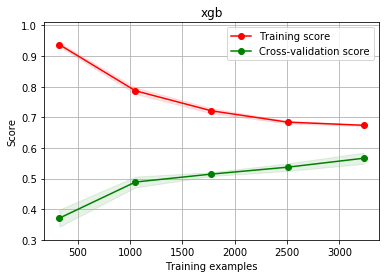

In [52]:
cv=StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
plot_learning_curve(xgb.XGBClassifier(random_state=2019), 'xgb', X, y, ylim=(0.3, 1.01), cv=cv)

Learning curves shows that model is overfitted. 

There are 299 features in data frame. Most of them are cathegorical. Another experiment was planned to reduce dimensionality and perform validation on the smaller data set. MCA technique has been used taking into consideration that there are a lot of categorical variables. 

In [109]:
col=list(df_c.columns[23:])
X=df_c[col]
ncol=len(col)
model=mca.MCA(X, ncols=ncol)

I've decided to use 180 components which allows to perceive more than 96% of variance:

In [110]:
np.sum(model.expl_var(greenacre=False,N=180))

0.9621162290123934

Reduced data frame:

In [111]:
np_mca=model.fs_r(N=180)
df_mca=pd.DataFrame(np_mca)

In [112]:
main_columns=['budget', 'popularity', 'revenue', 'runtime', 'release_year']
df_red_mca=pd.concat([df_c[main_columns], df_mca],axis=1)
df_red_mca.shape

(4042, 185)

As a result of MCA technique number of columns has been reduced from 299 to 185. Sample of new data set are visible below:

In [113]:
df_red_mca.sample(5)

,budget,popularity,revenue,runtime,release_year,0,1,2,3,4,...,170,171,172,173,174,175,176,177,178,179
3191,1.609438,14.574995,17.539047,115.0,1985,0.119455,-0.005075,0.102907,-0.052161,-0.015282,...,-0.004971,-0.050275,0.108656,0.072146,-0.021249,0.015186,0.029295,0.067478,-0.016879,0.129855
858,14.508660,23.962109,16.040134,153.0,1962,0.027395,0.079050,0.033576,-0.013382,-0.108539,...,0.007102,0.004917,0.022651,0.029002,-0.003308,0.006210,0.017084,0.023578,0.030003,0.041228
2487,16.523561,19.517239,17.025122,101.0,1996,0.123386,-0.070466,0.070438,-0.069578,-0.026501,...,-0.033340,0.090515,-0.033899,-0.014576,0.029348,-0.022091,0.042287,-0.053172,0.063366,-0.035892
2881,16.118096,16.785120,16.848857,103.0,1983,0.045476,-0.145820,0.045938,-0.055599,-0.052144,...,-0.043471,0.034706,0.035839,0.017522,-0.032962,-0.066235,0.026596,0.006535,0.026770,-0.033731
3757,13.122373,8.650779,11.920242,93.0,2002,0.079710,0.005180,0.045841,-0.023524,-0.084732,...,-0.007342,0.019602,0.034654,0.030986,-0.019021,-0.013772,0.001824,0.000353,0.028562,0.028614


Another step was to use reduced data set with classification models.

In [114]:
X=df_red_mca
y=df_c['vote_class']
models=[LogisticRegression(solver='lbfgs',random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019)]

for m in models:
    print('cv mean/std',model_train_predict(m, X, y,success_metric=accuracy_score))

LogisticRegression requires 5.1s.
cv mean/std (0.507, 0.009)
DecisionTreeClassifier requires 5.2s.
cv mean/std (0.417, 0.025)
RandomForestClassifier requires 2.6s.
cv mean/std (0.453, 0.025)
XGBClassifier requires 145.4s.
cv mean/std (0.537, 0.008)


In this case reduction of dimensionalities didn't help. Only in case of LogisticRegression model results are same and the time has decreased. In other models results are worse and estimators need more time. This example gives evidence that reduction might help but it all depends on data. 

### Visualization

Next step in this project concerned using of various visualisations techinques to investigate data, find clusters and reduce dimensionality. 

#### PCA
PCA with data reduced by MCA

In [126]:
df_red_mca=df_red_mca.fillna(-1)
X=df_red_mca.values
t0 = time.time()
pca = PCA(n_components=3)
X_reshape=pca.fit_transform(X) 
t1 = time.time()
print("PCA requires {:.1f}s.".format(t1 - t0))
print('variance by components: ', np.round(pca.explained_variance_ratio_,2))

PCA requires 0.1s.
variance by components:  [0.65 0.23 0.08]


In [116]:
np.sum(pca.explained_variance_ratio_)

0.9567680667409177

It is interesting that only three components allows to retain more than 95% variance.

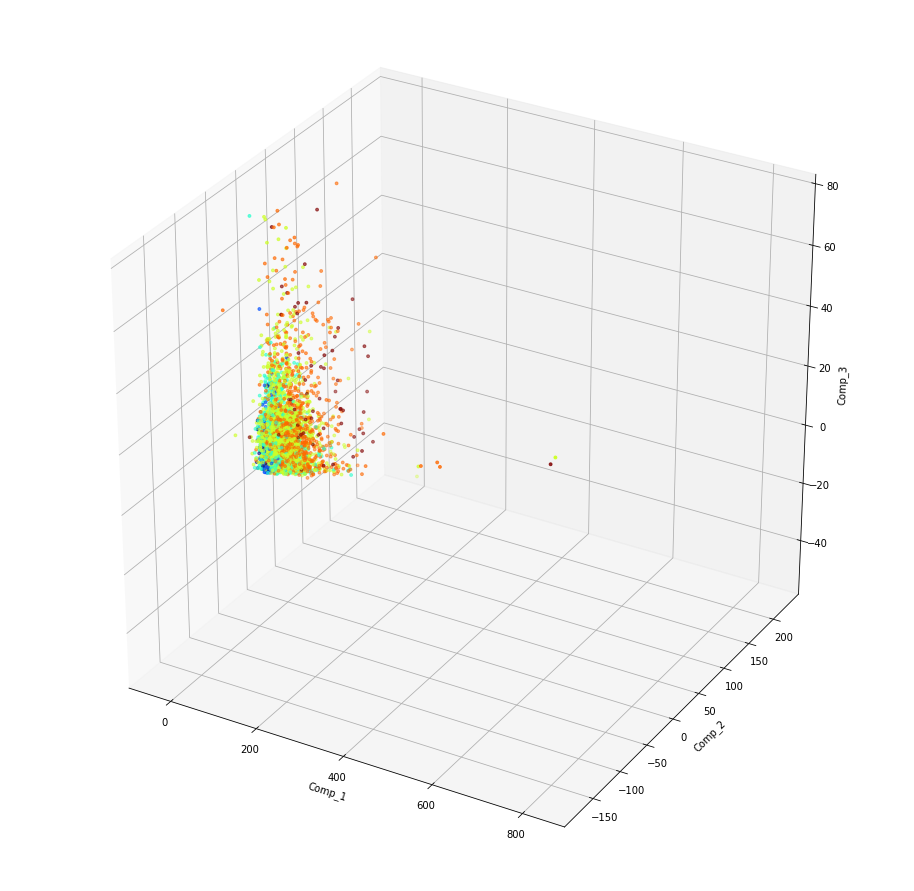

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 16))
ax3 = fig.add_subplot(111, projection='3d')

ax3.scatter(X_reshape[:,0], X_reshape[:,1], X_reshape[:,2],s=8,c=y,cmap="jet")
ax3.set_xlabel("Comp_1")
ax3.set_ylabel("Comp_2")
ax3.set_zlabel("Comp_3")
plt.show()

Visualization of two components compared with vote class is not clear, however there is some tendency that higher classes have bigger values of component1. PCA analysis is really fast. Let's compare with other techniques

#### TSNE

In [117]:
from sklearn.manifold import TSNE
X=df_red_mca.values
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsn = tsne.fit_transform(X)
t1 = time.time()
print("TSNE requires {:.1f}s.".format(t1 - t0))
y=df_c['vote_class']

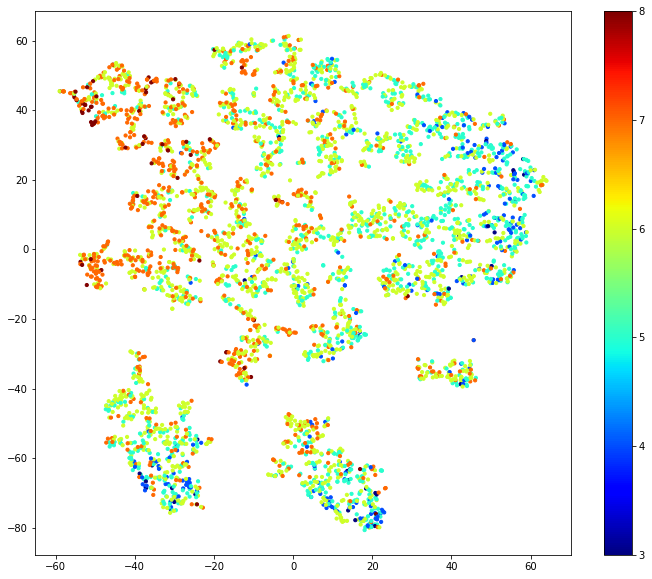

In [118]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsn[:, 0], X_tsn[:, 1], c=y, cmap="jet",s=10)
plt.colorbar()
plt.show()

In this case results are also rather not clear. There can be fond some clusters which are connected vote class but a lot of values are mixed.

#### LocallyLinearEmbedding

 LLE requires 3.0s.


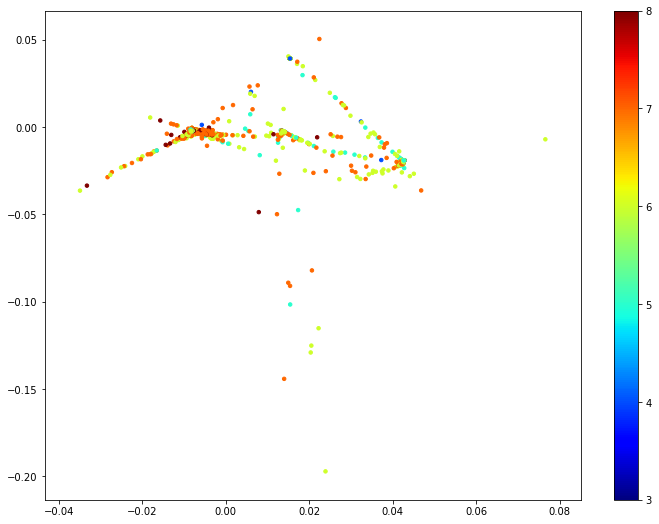

In [127]:
from sklearn.manifold import LocallyLinearEmbedding
plt.figure(figsize=(12,9))
X=df_red_mca.values
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print(" LLE requires {:.1f}s.".format(t1 - t0))
plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y, cmap="jet",s=12)
plt.colorbar()
plt.show()

LocallyLinearEmbedding didn't help in this case.

#### MDS

 MDS requires 1302.9s.


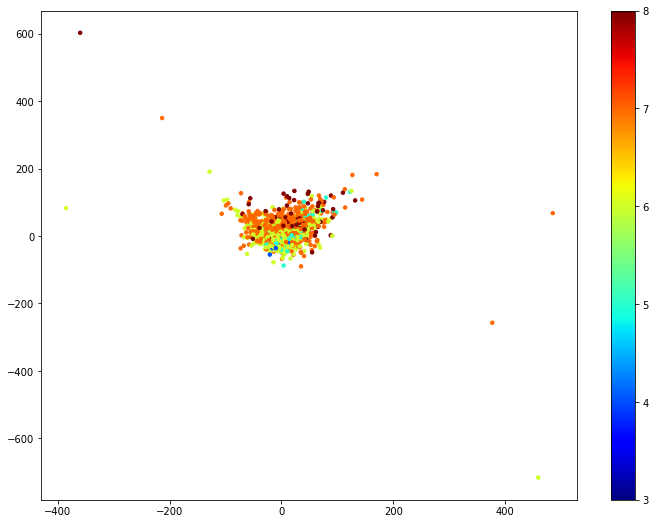

In [54]:
from sklearn.manifold import MDS
plt.figure(figsize=(12,9))
X=df_red_mca.values
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print(" MDS requires {:.1f}s.".format(t1 - t0))
plt.scatter(X_mds_reduced[:, 0], X_mds_reduced[:, 1], c=y, cmap="jet",s=12)
plt.colorbar()
plt.show()

All points have been into one cluster, definitely not helpful.

#### LinearDiscriminantAnalysis

LDA requires 0.2s.
explained variance:  [0.72477149 0.11603453]


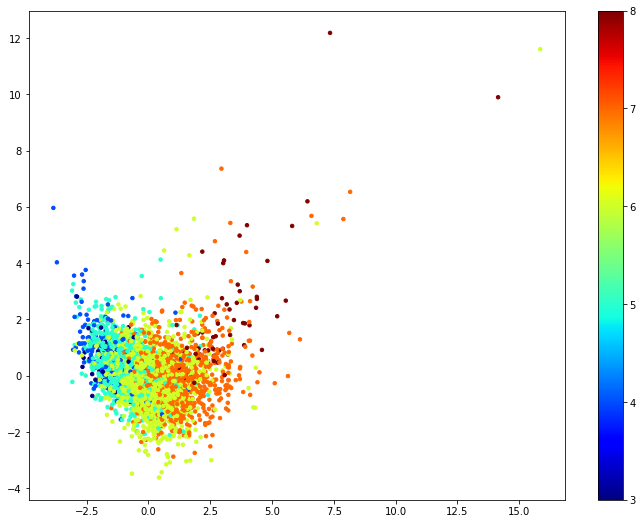

In [131]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
plt.figure(figsize=(12,9))
X=df_red_mca.values
t0 = time.time()
lda=LinearDiscriminantAnalysis(n_components=2)
X_lda_reduced = lda.fit_transform(X, y)
t1 = time.time()
print("LDA requires {:.1f}s.".format(t1 - t0))
print("explained variance: ", lda.explained_variance_ratio_ )
plt.scatter(X_lda_reduced[:, 0], X_lda_reduced[:, 1], c=y, cmap="jet",s=12)
plt.colorbar()
plt.show()

The results are interesting even with only two components which explained about 84% of variance. Lower classes are on the left and moving into right of x axe (1st component) there are higher classes.
Algorithm is also really fast.

#### KMeans clustering
Data has been divided into 6 clusters (number of vote class categories). The results have been compared with real classes.

In [164]:
X=df_red_mca.values
kmean=KMeans(random_state=2010,n_clusters=6)
kmean.fit(X)
clusters=kmean.labels_

df_c['cluster']=clusters

In [161]:
df_c['vote_class'].value_counts()

6    1778
5    1100
7     831
4     234
8      62
3      37
Name: vote_class, dtype: int64

In [165]:
df_c['cluster'].value_counts()

1    1816
2    1018
5     842
3     191
0     169
4       6
Name: cluster, dtype: int64

Classes 6, 5, 7 might be linked with cluster 1, 2, 5. Cluster 3 or 0 may concern class 8. There is also cluster which was very rare - only 6 objects. Let's check more precisely.

In [166]:
vote_class=list(set(df_c['vote_class']))
for j in vote_class:
    print('Class: ', j)
    print(df_c[df_c['vote_class']==j]['cluster'].value_counts(normalize=False))

Class:  3
1    34
2     2
5     1
Name: cluster, dtype: int64
Class:  4
1    203
2     18
5     13
Name: cluster, dtype: int64
Class:  5
1    699
2    198
5    179
3     18
0      6
Name: cluster, dtype: int64
Class:  6
1    710
2    548
5    399
0     60
3     59
4      2
Name: cluster, dtype: int64
Class:  7
2    245
5    236
1    166
0     94
3     87
4      3
Name: cluster, dtype: int64
Class:  8
3    27
5    14
0     9
2     7
1     4
4     1
Name: cluster, dtype: int64


Cluster 3 and 5 focused mainly objects from class 8. Clusters 1, 2, 5  concerns vaste majority of objects from classees 3, 4, 5, 6 however distribution shows that model have problems to distinguish differences between classess.

In [176]:
df_c[df_c['vote_class']==8][['original_title','cluster']].sample(20)

,original_title,cluster
3539,Whiplash,3
77,Inside Out,3
1824,Scarface,0
3440,Anne of Green Gables,0
2656,Room,5
3040,Star Wars: Clone Wars (Volume 1),1
2902,One Direction: This Is Us,1
491,The Lion King,3
687,The Green Mile,3
1503,Apocalypse Now,0


In [177]:
df_c[df_c['cluster']==3][['original_title','vote_class']].sample(20)

,original_title,vote_class
659,Fight Club,8
85,Captain America: The Winter Soldier,7
632,Apollo 13,7
786,American Sniper,7
119,Batman Begins,7
47,Star Trek Into Darkness,7
2128,Psycho,8
2228,The Shining,8
3009,The Purge: Anarchy,6
199,Pirates of the Caribbean: The Curse of the Bla...,7


This cluster concerns movies with vote 6 and higher.

In [178]:
df_c[df_c['cluster']==1][['original_title','vote_class']].sample(20)

,original_title,vote_class
3524,Gods and Monsters,6
3428,Spun,6
923,Christmas with the Kranks,5
2186,A Scanner Darkly,6
3162,Get Low,6
3450,Porky's,6
3664,Idiocracy,6
3098,Clay Pigeons,6
2159,The Weather Man,6
449,Flubber,5


In [ ]:
This cluster concerns movies with vote 6 and lower.

#### Conclusions
* there are a lot techniques of dimensionalitiy reduction, their usefulness depends on data
* reduction of dimensionalities might improve performance of model but it also depends on data and model, even with perceiving variance model might get worse.
* some additional activities like hyperparameter optimizning should be performed
* NLP might be checked for text data (for example plot, keywords)